In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True, return_X_y=True)
df, target = data[0], data[1] 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


1. Данные о недвижемости содержат информаю по 8 характеристикам недвижемости, всего 20640 записей. Пропусков в данных нет.
2. Все характеристики (переменные) имеют числовое значение (непрерывное числовое значение), тип float64

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


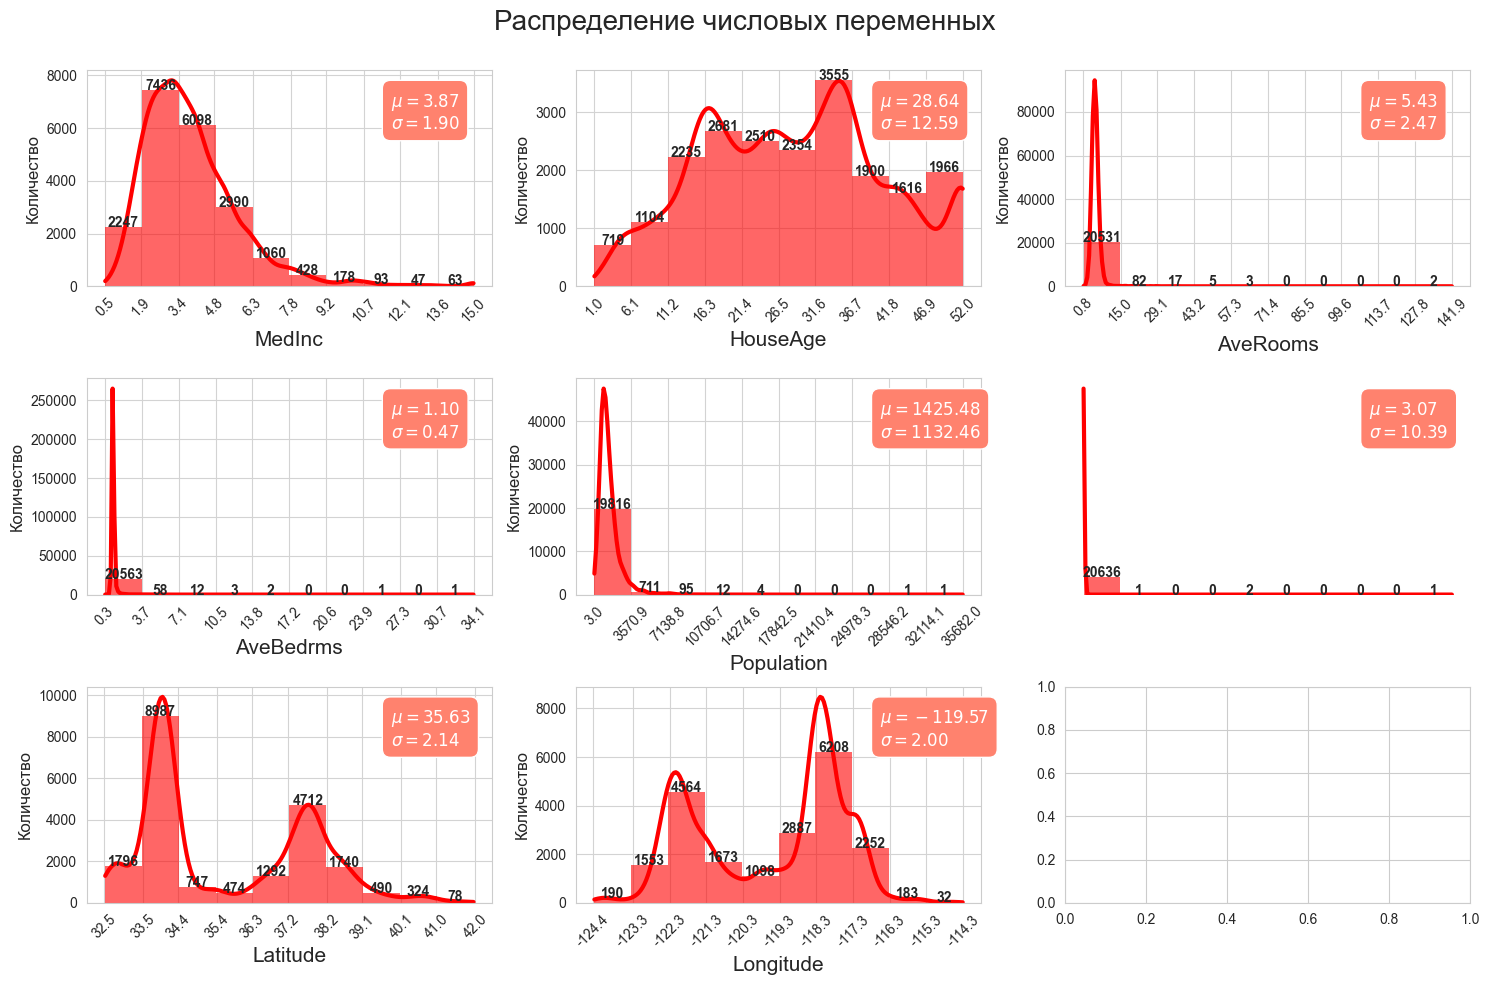

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Цикл для построения гистограмм для каждого числового признака
for i, col in enumerate(df.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df[col],
                                     range=(df[col].min(), df[col].max()))

    graph = sns.histplot(data=df, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Количество', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df[col].mean(),
        r'$\sigma=%.2f$' % df[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Распределение числовых переменных', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

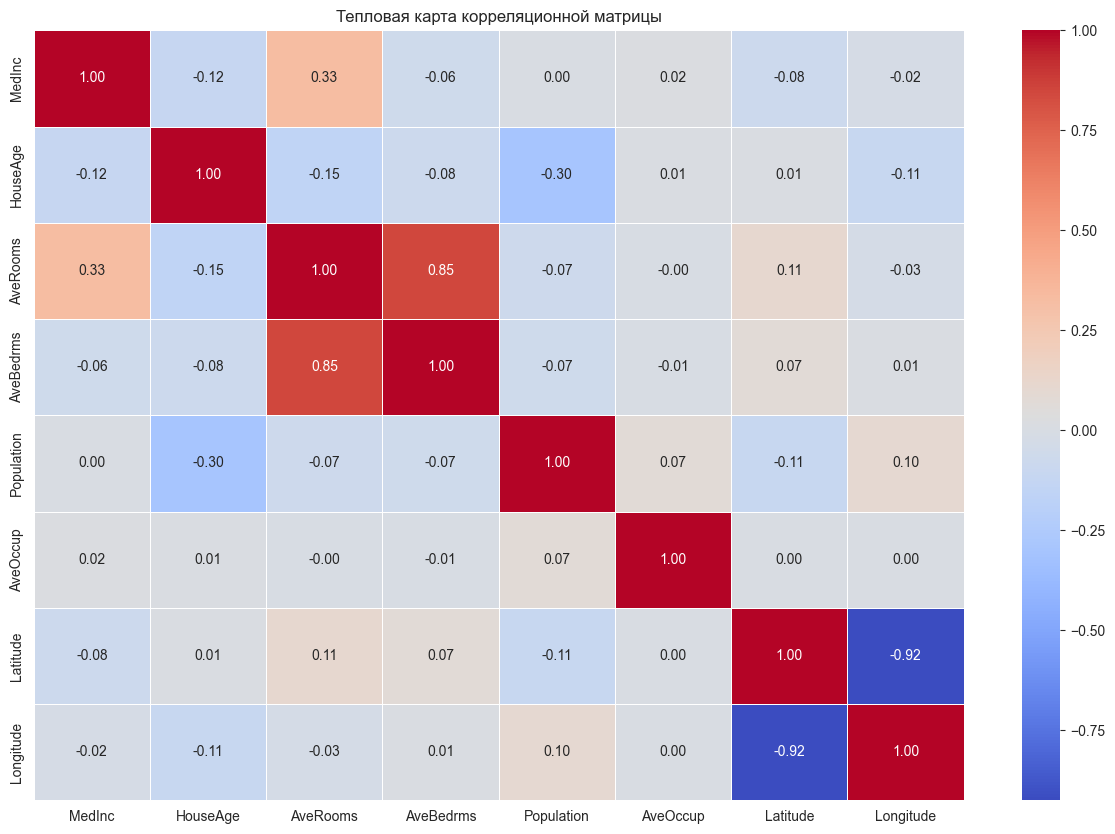

In [6]:
correlation_matrix = df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Тепловая карта корреляционной матрицы")
plt.show()

*Из построенной матрицы корреляции видно, что сильная обратная корреляция (-0.92) существует между показателями Latitude и Longitude, поэтому вместе эти показатели лучше не использовать, из-за риска появления мультиколлиниарности.
Кроме того слабая корреляция существует еще между следующими признаками MedInc и AveRooms (0.33); HouseAge и Population (-0.3)*

### Построение моделей:
- Разделите данные на обучающую и тестовую выборки.
- Постройте и обучите модели RandomForestRegressor и GradientBoostingRegressor.
- Постарайтесь оптимизировать их гиперпараметры для улучшения результатов на обучающей выборке.
- Оцените качество моделей на тестовой выборке с использованием метрик RMSE (Root Mean Squared Error) и R² (коэффициент детерминации).
- Сравните результаты моделей, интерпретируйте их.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

X = df
y = target

#Разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Создание и обучение ансамбля RandomForest
forest_model = RandomForestRegressor(n_estimators=200, random_state=42)
forest_model.fit(X_train, y_train)
forest_predictions_train = forest_model.predict(X_train)
forest_predictions_test = forest_model.predict(X_test)
forest_r2_train = r2_score(y_train, forest_predictions_train)
forest_r2_test = r2_score(y_test, forest_predictions_test)
forest_RMSE_train = root_mean_squared_error(y_train, forest_predictions_train)
forest_RMSE_test = root_mean_squared_error(y_test, forest_predictions_test)

print(f"R^2 для RandomForestRegressor train: {forest_r2_train}")
print(f"R^2 для RandomForestRegressor test: {forest_r2_test}")
print(f"RMSE для RandomForestRegressor train: {forest_RMSE_train}")
print(f"RMSE для RandomForestRegressor test: {forest_RMSE_test}")

R^2 для RandomForestRegressor train: 0.974202863308669
R^2 для RandomForestRegressor test: 0.8062009933635497
RMSE для RandomForestRegressor train: 0.18570150849017034
RMSE для RandomForestRegressor test: 0.5039404312719632
CPU times: total: 19.2 s
Wall time: 20 s


In [15]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

# Создание и обучение ансамбля GradientBoostingRegressor
boosting_model = GradientBoostingRegressor(n_estimators=200, random_state=42)
boosting_model.fit(X_train, y_train)
boosting_predictions_train = boosting_model.predict(X_train)
boosting_predictions_test = boosting_model.predict(X_test)
boosting_r2_train = r2_score(y_train, boosting_predictions_train)
boosting_r2_test = r2_score(y_test, boosting_predictions_test)
boosting_RMSE_train = root_mean_squared_error(y_train, boosting_predictions_train)
boosting_RMSE_test = root_mean_squared_error(y_test, boosting_predictions_test)

# Сравнение результатов
print(f"R^2 для GradientBoostingRegressor train: {boosting_r2_train}")
print(f"R^2 для GradientBoostingRegressor test: {boosting_r2_test}")
print(f"RMSE для GradientBoostingRegressor train: {boosting_RMSE_train}")
print(f"RMSE для GradientBoostingRegressor test: {boosting_RMSE_test}")
print(f"Улучшение в R^2 (FOREST - BOOSTING) train: {forest_r2_train - boosting_r2_train}")
print(f"Улучшение в R^2 (FOREST - BOOSTING) test: {forest_r2_test - boosting_r2_test}")
print(f"Улучшение в RMSE (FOREST - BOOSTING) train: {forest_RMSE_train - boosting_RMSE_train}")
print(f"Улучшение в RMSE (FOREST - BOOSTING) test: {forest_RMSE_test - boosting_RMSE_test}")

R^2 для GradientBoostingRegressor train: 0.8358544068105361
R^2 для GradientBoostingRegressor test: 0.8004451261281281
RMSE для GradientBoostingRegressor train: 0.46842955984536916
RMSE для GradientBoostingRegressor test: 0.511369238782928
Улучшение в R^2 (FOREST - BOOSTING) train: 0.13834845649813288
Улучшение в R^2 (FOREST - BOOSTING) test: 0.005755867235421541
Улучшение в RMSE (FOREST - BOOSTING) train: -0.28272805135519885
Улучшение в RMSE (FOREST - BOOSTING) test: -0.007428807510964752
CPU times: total: 5.3 s
Wall time: 5.62 s


### Оптимизация гиперпараметров

In [16]:
depths = [3, 5, 7, 9, 10]
splits = [2, 5, 10, 15, 20]
samples_leaf = [2, 3, 4, 5, 6]
for depth in depths:
    for split in splits:
        for leaf in samples_leaf:
            forest_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            forest_model.fit(X_train, y_train)
            forest_predictions_test = forest_model.predict(X_test)
            r2 = r2_score(y_test, forest_predictions_test)
            print(f"Глубина дерева: {depth}, минимальное число образцов в узле: {split}, минимальное количество образцов {leaf} R^2: {r2}")

Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 2 R^2: 0.539796940650872
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 3 R^2: 0.539796940650872
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 4 R^2: 0.539796940650872
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 5 R^2: 0.5397961113402242
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 6 R^2: 0.5397969626329985
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образцов 2 R^2: 0.539796940650872
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образцов 3 R^2: 0.539796940650872
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образцов 4 R^2: 0.539796940650872
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образц

Самое высокое качество модели Случайный лес на тестовой выборке = 0.77579 при следующих параметрах модели:
- Максимальная глубина дерева = 10
- Минимальное число образцов в узле = 2 
- Минимальное количество образцов = 3 

In [17]:
depths = [3, 5, 7, 9, 10]
splits = [2, 5, 10, 15, 20]
samples_leaf = [2, 3, 4, 5, 6]
for depth in depths:
    for split in splits:
        for leaf in samples_leaf:
            gbm = GradientBoostingRegressor(n_estimators=200, random_state=42, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            gbm.fit(X_train, y_train)
            predictions_test = gbm.predict(X_test)
            r2 = r2_score(y_test, predictions_test)
            print(f"Глубина дерева: {depth}, минимальное число образцов в узле: {split}, минимальное количество образцов {leaf} R^2: {r2}")

Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 2 R^2: 0.8000158630575082
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 3 R^2: 0.7994186541151173
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 4 R^2: 0.8021242542613324
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 5 R^2: 0.8009831524431047
Глубина дерева: 3, минимальное число образцов в узле: 2, минимальное количество образцов 6 R^2: 0.8007869524331308
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образцов 2 R^2: 0.800427943321707
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образцов 3 R^2: 0.7994186541151173
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество образцов 4 R^2: 0.8021242542613324
Глубина дерева: 3, минимальное число образцов в узле: 5, минимальное количество о

Самое высокое качество модели Градиентный бустинг на тестовой выборке = 0.844 при следующих параметрах модели:
- Максимальная глубина дерева = 9
- Минимальное число образцов в узле = 15 
- Минимальное количество образцов = 2 

### Анализ важности признаков и выводы:
- Используйте атрибут feature_importances_ для оценки важности признаков в каждой модели.
- на основе полученных данных сделайте выводы о том, какие признаки наиболее значимы и почему.

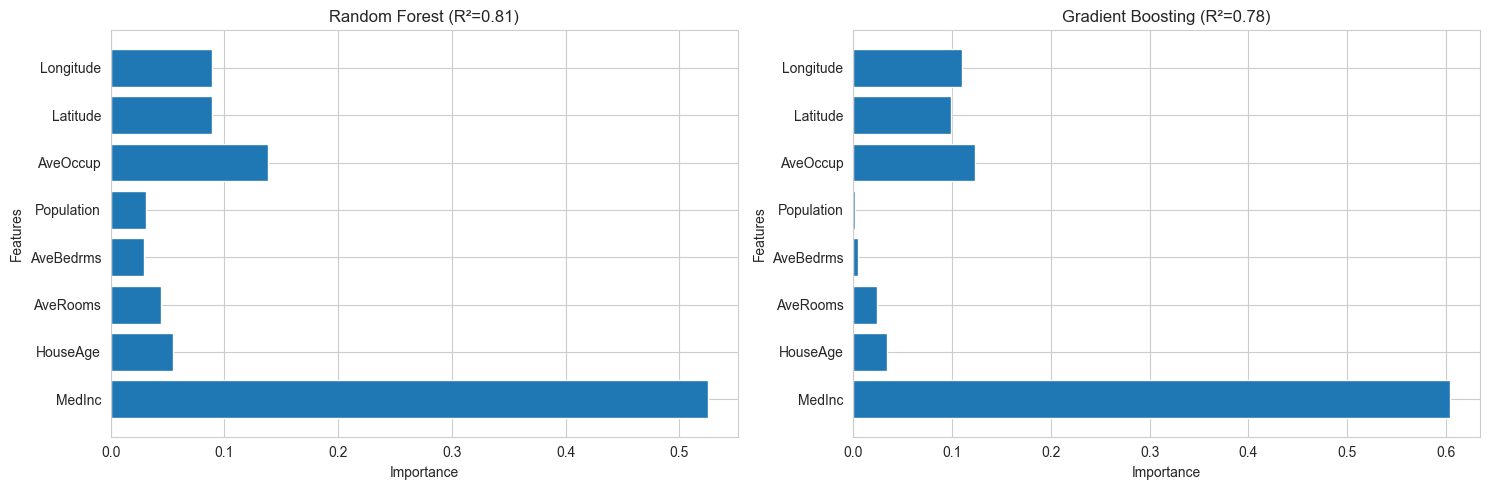

In [19]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Обучение моделей и оценка важности признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    score = r2_score(y_test, model.predict(X_test))
    feature_importances = model.feature_importances_

    ax.barh(np.arange(len(feature_importances)), feature_importances, align='center')
    ax.set_yticks(np.arange(len(X.columns)))
    ax.set_yticklabels(X.columns)
    ax.set_title(f'{name} (R²={score:.2f})')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')

plt.tight_layout()
plt.show()

#### Сравнение производительности моделей
На графиках показаны важности признаков для двух моделей: Random Forest и Gradient Boosting, а также их коэффициенты детерминации (R²).
- Random Forest R² = 0.81
- Gradient Boosting R² = 0.78
Обе модели Random Forest и Gradient Boosting работают достаточно хорошо.
При этом модели показывают разное время обучения:
- Random Forest R² = 19.2 с
- Gradient Boosting R² = 5.3 с
Время расчета необходимо учитывать, если мое=дель будет запускаться часто и на больших обемах данных , при близких значениях коэффициента детирменации выбор должен  быть в пользу более быстрой модели.

#### Анализ важности признаков

Исходя из проведенного анализа, можно выделить ключевые признаки, которые оказали наибольшее влияние на прогноз:

1. MedInc (средний доход в группе блоков): Этот признак оказался самым важным в моделях Random Forest и Gradient Boosting.
2. AveOccup (среднее количество членов домохозяйства): Этот признак занимает второе место по значимости в моделях Random Forest и Gradient Boosting.
3. Latitude и Longitude (ширина и долгота): Признакитакже имеют значительное влияние в обоих моделях.


Не сильно важные признаки: Population(население) AveBedrums (среднее количество спален на семью) имеют самоемалое влияние во всех моделях. 